In [ ]:
#pip install opencv-python



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
image = cv2.imread('/Users/satya/Documents/Abhilasha/OTH_Sem3/AR:VR/Project/Task_code/DC_1st floor.jpg',cv2.IMREAD_GREYSCALE)  # Replace with your image path



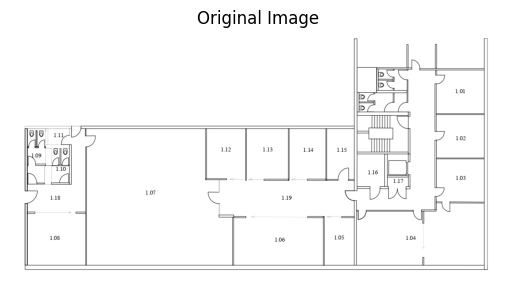

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title('Original Image')
plt.axis('off')
plt.show()


2024-11-25 18:56:48.883 Python[11657:470162] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


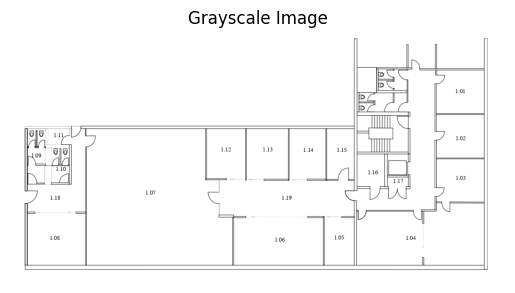

In [ ]:
#Convert Image into gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', gray_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()
